# Custom object detector

Reference: 06 transfer learning

In [1]:
import torch
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.0.1+cu117
torchvision version: 0.15.2+cu117


In [2]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from torchinfo import summary
import cv2
from typing import List, Tuple
from PIL import Image
import imutils
from pathlib import Path

from torchvision import transforms as T

import model
import engine
from utils import (
    set_seed, 
    plot_loss_curves, 
    create_confusion_matrix, 
    save_model, 
    pred_and_plot_img, 
    crawl_through_dir, 
    visualize_dataset)
import config
import dataset


/home/kpatel2s/miniconda3/envs/pytorch_practice/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
NUM_WORKERS = config.NUM_WORKERS
BATCH_SIZE = config.BATCH_SIZE
PIN_MEMORY = config.PIN_MEMORY

num_classes = config.NUM_CLASSES

IMAGE_SIZE = config.IMAGE_SIZE

EPOCHS = config.EPOCHS
LR_RATE = config.LR_RATE

In [4]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


### Load the dataset

In [5]:
# Setup path to data folder
data_path = Path(config.DATASET)

# image files paths and annotations
images_path = os.path.join(data_path, "images")
annotations_path = os.path.join(data_path, "yolo", "annotations")

images_path, annotations_path

('dataset/standford_dogs_mini_10/images',
 'dataset/standford_dogs_mini_10/yolo/annotations')

### Create data loaders

In [6]:
train_dataloader = dataset.create_dataloader(
    images_path=images_path,
    annotations_path=annotations_path,
    subset="train",
    batch_size=BATCH_SIZE,
    pin_memory=PIN_MEMORY,
    transforms=None,
    num_workers=NUM_WORKERS
)

valid_dataloader = dataset.create_dataloader(
    images_path=images_path,
    annotations_path=annotations_path,
    subset="valid",
    batch_size=BATCH_SIZE,
    pin_memory=PIN_MEMORY,
    transforms=None,
    num_workers=NUM_WORKERS
)

test_dataloader = dataset.create_dataloader(
    images_path=images_path,
    annotations_path=annotations_path,
    subset="test",
    batch_size=1,
    pin_memory=PIN_MEMORY,
    transforms=None,
    num_workers=NUM_WORKERS
)

print(f"train_dataloader: {train_dataloader}")
print(f"test_dataloader: {valid_dataloader}")
print(f"class_names: {config.CLASS_NAMES}")

train_dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f480f74d450>
test_dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f4808756c10>
class_names: ['Chihuahua', 'Golden_retriever', 'Welsh_springer_spaniel', 'German_shepherd', 'Doberman', 'Boxer', 'Siberian_husky', 'Pug', 'Pomeranian', 'Cardigan']


### Visualize samples from the dataset

<Figure size 2000x2000 with 0 Axes>

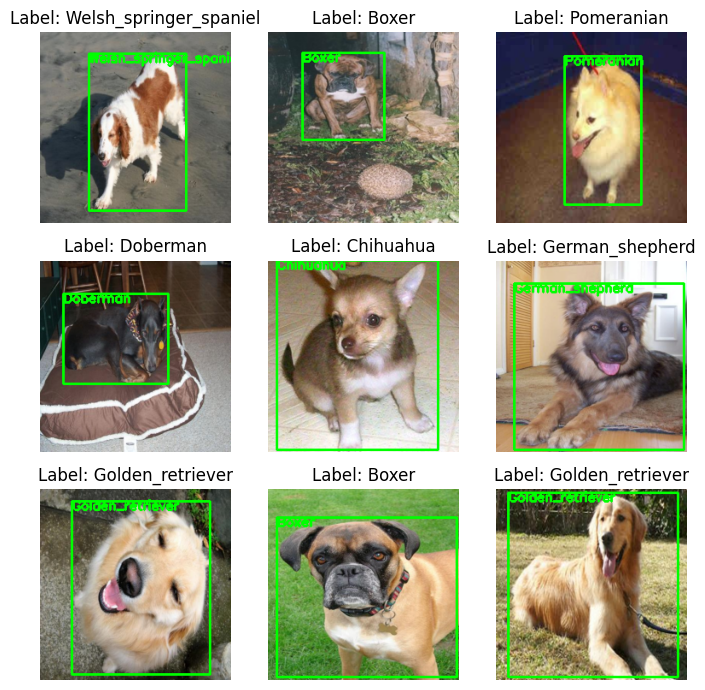

In [7]:
visualize_dataset(train_dataloader)

### Setup the model

In [8]:
# Create the network
weights = torchvision.models.ResNet50_Weights.DEFAULT
basemodel = torchvision.models.resnet50(weights=weights)

model = model.ObjectDetector(basemodel, num_classes)

#### Get the model summary

In [9]:
x = torch.randn((1, 3, IMAGE_SIZE, IMAGE_SIZE))    

summary(model=model, 
        input_size=(1, 3, IMAGE_SIZE, IMAGE_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

# NOTE: all layers are trainable

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
ObjectDetector (ObjectDetector)               [1, 3, 224, 224]     [1, 10]              --                   True
├─ResNet (backbone)                           [1, 3, 224, 224]     [1, 2048]            --                   True
│    └─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    9,408                True
│    └─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    128                  True
│    └─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
│    └─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
│    └─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   True
│    │    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56, 56]    

#### Freeze ResNet50 weights (backbone)

In [10]:
for param in model.backbone.parameters():
    param.requires_grad = False

In [11]:
x = torch.randn((1, 3, IMAGE_SIZE, IMAGE_SIZE))    

summary(model=model, 
        input_size=(1, 3, IMAGE_SIZE, IMAGE_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

# NOTE: all ResNet50 layers are not trainable (False) and only 
# classification and bbox regression layers are trainable (True)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
ObjectDetector (ObjectDetector)               [1, 3, 224, 224]     [1, 10]              --                   Partial
├─ResNet (backbone)                           [1, 3, 224, 224]     [1, 2048]            --                   False
│    └─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
│    └─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
│    └─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
│    └─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
│    └─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    │    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56, 

### Loss function and optimizer

In [12]:
# Two loss functions
classLoss_function = torch.nn.CrossEntropyLoss()
bboxLoss_function = torch.nn.MSELoss()
loss_fn = (classLoss_function, bboxLoss_function)

# Optimizer
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=LR_RATE)

### Train the model

In [13]:
set_seed(seed=config.SEED)

from timeit import default_timer as timer
start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=valid_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=EPOCHS,
                       device=device)

end_time = timer()
print(f"Time elapsed: {end_time - start_time:.3f} seconds")

# Save model
save_model(model=model, target_dir="models", model_name=f"model_{EPOCHS}.pth")

 10%|█         | 1/10 [00:04<00:40,  4.51s/it]

Epoch: 1 | train_loss: 2.3730 | train_cls_loss: 2.2346 | train_bbox_loss: 0.1384 | train_acc: 0.3073 | test_loss: 2.2290 | test_cls_loss: 2.0998 | test_bbox_loss: 0.1292 | test_acc: 0.6721


 20%|██        | 2/10 [00:08<00:34,  4.33s/it]

Epoch: 2 | train_loss: 2.0541 | train_cls_loss: 1.9468 | train_bbox_loss: 0.1073 | train_acc: 0.6089 | test_loss: 1.6640 | test_cls_loss: 1.5773 | test_bbox_loss: 0.0867 | test_acc: 0.8679


 30%|███       | 3/10 [00:12<00:30,  4.29s/it]

Epoch: 3 | train_loss: 1.3910 | train_cls_loss: 1.3365 | train_bbox_loss: 0.0546 | train_acc: 0.8327 | test_loss: 0.8770 | test_cls_loss: 0.8359 | test_bbox_loss: 0.0411 | test_acc: 0.9563


 40%|████      | 4/10 [00:17<00:25,  4.30s/it]

Epoch: 4 | train_loss: 0.7382 | train_cls_loss: 0.7113 | train_bbox_loss: 0.0269 | train_acc: 0.9244 | test_loss: 0.4097 | test_cls_loss: 0.3802 | test_bbox_loss: 0.0296 | test_acc: 0.9812


 50%|█████     | 5/10 [00:21<00:21,  4.27s/it]

Epoch: 5 | train_loss: 0.4394 | train_cls_loss: 0.4170 | train_bbox_loss: 0.0223 | train_acc: 0.9338 | test_loss: 0.2350 | test_cls_loss: 0.2070 | test_bbox_loss: 0.0279 | test_acc: 0.9875


 60%|██████    | 6/10 [00:25<00:17,  4.31s/it]

Epoch: 6 | train_loss: 0.2849 | train_cls_loss: 0.2630 | train_bbox_loss: 0.0219 | train_acc: 0.9582 | test_loss: 0.1660 | test_cls_loss: 0.1383 | test_bbox_loss: 0.0277 | test_acc: 0.9875


 70%|███████   | 7/10 [00:30<00:12,  4.29s/it]

Epoch: 7 | train_loss: 0.2113 | train_cls_loss: 0.1906 | train_bbox_loss: 0.0207 | train_acc: 0.9713 | test_loss: 0.1208 | test_cls_loss: 0.0947 | test_bbox_loss: 0.0261 | test_acc: 0.9875


 80%|████████  | 8/10 [00:34<00:08,  4.30s/it]

Epoch: 8 | train_loss: 0.1692 | train_cls_loss: 0.1492 | train_bbox_loss: 0.0200 | train_acc: 0.9767 | test_loss: 0.0917 | test_cls_loss: 0.0663 | test_bbox_loss: 0.0253 | test_acc: 0.9938


 90%|█████████ | 9/10 [00:38<00:04,  4.32s/it]

Epoch: 9 | train_loss: 0.1514 | train_cls_loss: 0.1324 | train_bbox_loss: 0.0191 | train_acc: 0.9740 | test_loss: 0.0769 | test_cls_loss: 0.0531 | test_bbox_loss: 0.0239 | test_acc: 0.9938


100%|██████████| 10/10 [00:43<00:00,  4.31s/it]

Epoch: 10 | train_loss: 0.1147 | train_cls_loss: 0.0967 | train_bbox_loss: 0.0181 | train_acc: 0.9836 | test_loss: 0.0716 | test_cls_loss: 0.0490 | test_bbox_loss: 0.0226 | test_acc: 0.9938
Time elapsed: 43.123 seconds
[INFO] Saving model to: models/model_10.pth


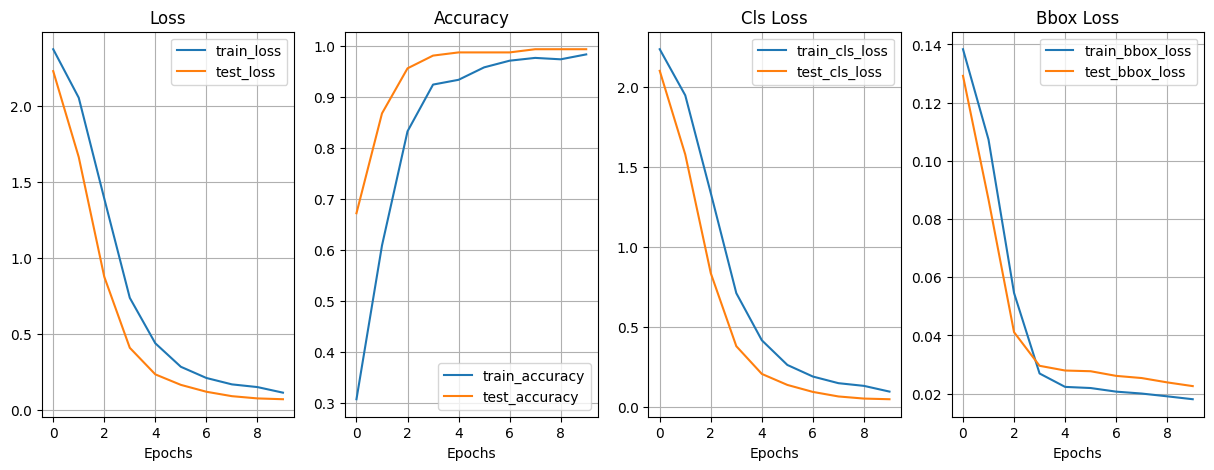

In [14]:
# Evaluation
plot_loss_curves(results=results)

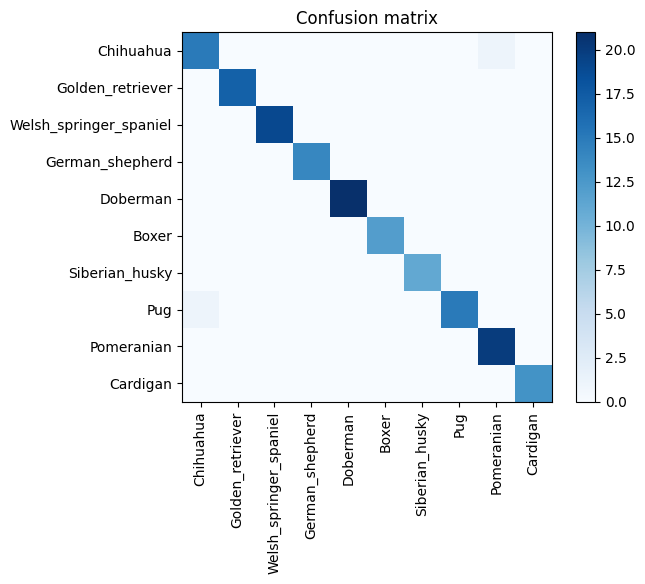

In [15]:
create_confusion_matrix(model=model,
                        test_loader=test_dataloader,
                        class_names=config.CLASS_NAMES,
                        device=device)

### Inference on images

In [16]:
if config.LOAD_MODEL:
    # load the model weights
    weights_file = config.MODEL_PATH
    model.load_state_dict(torch.load(weights_file))

<Figure size 2000x2000 with 0 Axes>

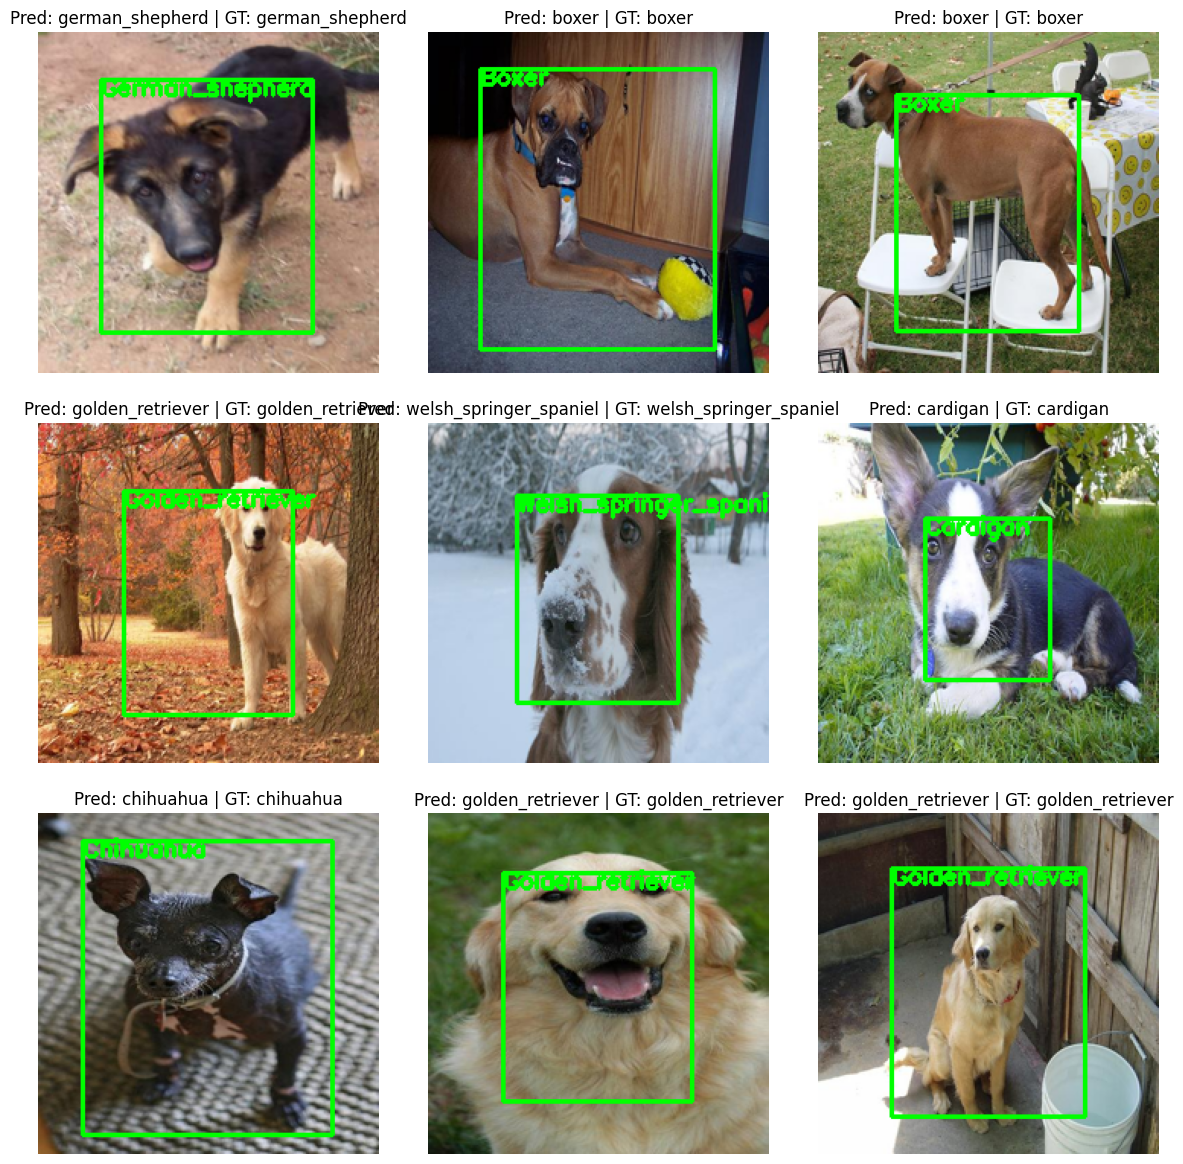

In [17]:
test_dir = "/home/kpatel2s/kpatel2s/object_detection/custom_object_detector/dataset/standford_dogs_mini_10/images"

num_imgs = 9
test_img_path_list = crawl_through_dir(test_dir)
test_img_path_sample = random.sample(test_img_path_list, num_imgs)

# Set figure size
plt.figure(figsize=(20, 20)) 

# Set subplot parameters
plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

for i, test_img in enumerate(test_img_path_sample):
    # plot output images
    plt.subplot(3, 3, i+1)
    image, label, gt_label = pred_and_plot_img(model=model,
                    img_path=test_img,
                    class_names=config.CLASS_NAMES,
                    img_size=(config.IMAGE_SIZE, config.IMAGE_SIZE),
                    transform=None,
                    device=device)
    plt.axis("off")
    plt.imshow(image)
    plt.title(f"Pred: {label.lower()} | GT: {gt_label.lower()}")

plt.tight_layout(pad=2.0)

### Benchmark on Test dataset

# TODO

- add tensorboard
- add mAP metric from torchmetrics
- make modular code